In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Dataloader

In [2]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_values = np.identity(n_classes)
        return [onehot_values[int(label)] for label in labels]
    
    def __shuffle_dataset(self):
        indices = np.arange(len(self.__data))
        np.random.shuffle(indices)
        self.__data = np.array([self.__data[i] for i in indices])
        self.__onehot_labels = np.array([self.__onehot_labels[i] for i in indices])
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [3]:
class Identical:
    
    def __init__(self): pass
    
    def __identical(self, matrix):
        matrix = np.matrix(matrix, dtype=float)
        return matrix

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        return np.matrix(np.full(np.shape(temp), 1.))
    
    def __call__(self, matrix):
        return self.__identical(matrix)
    
    def __repr__(self):
        return 'ReLu'
    
    def __str__(self):
        return 'ReLu'
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        result = np.matrix(matrix, dtype=float)
        result[result < 0] = 0
        return result

    def derivative(self, matrix):
        result = np.matrix(matrix, dtype=float)
        result[result < 0] = 0
        result[result > 0] = 1
        return result
    
    def __call__(self, matrix):
        return self.__relu(matrix)
    
    def __repr__(self):
        return 'ReLu'
    
    def __str__(self):
        return 'ReLu'

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __leaky_relu(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        return np.maximum(temp, temp*self.negative_slope)

    def derivative(self, matrix):
        result = np.matrix(matrix, dtype=float)
        result[result > 0] = 1
        result[result < 0] = self.negative_slope
        return result
    
    def __call__(self, matrix):
        return self.__leaky_relu(matrix)
    
    def __repr__(self):
        return 'LeakyReLu'
    
    def __str__(self):
        return 'LeakyReLu'

    
class Sigmoid:
    
    def __init__(self): pass

    def __sigmoid(self, matrix):
        return np.matrix(1/(1+np.exp(matrix)))

    def derivative(self, matrix):
        sigmoid = sigmoid(matrix)
        return np.multiply(sigmoid, (1- sigmoid))
    
    def __call__(self, matrix):
        return self.__sigmoid(matrix)
    
    def __repr__(self):
        return 'Sigmoid'
    
    def __str__(self):
        return 'Sigmoid'


class Softmax:
    
    def __init__(self): pass

    def __softmax(self, matrix):
        temp = np.exp(matrix-np.max(matrix, axis=-1)+10.)
        return np.divide(temp, np.matrix(np.sum(temp, axis=1)))

    def derivative(self, matrix):
        temp = self(matrix)
        return np.multiply(temp, 1.-temp)
    
    def __call__(self, matrix):
        return self.__softmax(matrix)
    
    def __repr__(self):
        return 'Softmax'
    
    def __str__(self):
        return 'Softmax'

# Loss Functions

In [4]:
class MSE:
    
    def __init__(self): pass

    def __mse(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        true_val, expected_val = np.matrix(true_val).copy(), np.matrix(expected_val).copy()
        return np.mean(np.power(true_val - expected_val, 2), -1)

    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        true_val, expected_val = np.matrix(true_val).copy(), np.matrix(expected_val).copy()
        return 2*(true_val - expected_val)  
    
    def __call__(self, true_val, expected_val):
        return self.__mse(true_val, expected_val)
    
    def __repr__(self):
        return 'MSE'
    
    def __str__(self):
        return 'MSE'
    

class CrossEntropy:
    
    __EPSILON = 1e-2
    __SOFTMAX = Softmax()
    
    def __init__(self): pass

    def __cross_entropy(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        return np.mean(-np.multiply(np.matrix(np.log((self.__SOFTMAX(true_val)+self.__EPSILON))), expected_val), -1)

    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        return np.matrix(self.__SOFTMAX(true_val)-expected_val)
    
    def __call__(self, true_val, expected_val):
        return self.__cross_entropy(true_val, expected_val)
    
    def __repr__(self):
        return 'CrossEntropy'
    
    def __str__(self):
        return 'CrossEntropy'

# Weight Initialization

In [5]:
DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR, DEFAULT_SAME = 0, 0.05, 0., 1., 0.

def uniform_weight(dim1, dim2, **initializer_parameters):
    low, high = DEFAULT_LOW, DEFAULT_HIGH
    if 'low' in initializer_parameters.keys(): low = initializer_parameters['low']
    if 'high' in initializer_parameters.keys(): high = initializer_parameters['high']
    return np.matrix(np.random.uniform(low=low, high=high, size=(dim1, dim2)))
  

def normal_weight(dim1, dim2, **initializer_parameters):
    mean, var = DEFAULT_MEAN, DEFAULT_VAR
    if 'mean' in initializer_parameters.keys(): mean = initializer_parameters['mean']
    if 'var' in initializer_parameters.keys(): var = initializer_parameters['var']
    return var * np.matrix(np.random.randn(dim1, dim2)) + mean
  
    
def same_weight(dim1, dim2, **initializer_parameters):
    value = DEFAULT_SAME
    if 'value' in initializer_parameters.keys(): value = initializer_parameters['value']
    return np.matrix(np.ones([dim1, dim2])) + value

# Layer

In [6]:
class Layer:
    
    __weight_initializer_dict = {'uniform':uniform_weight, 'normal':normal_weight, 'same':same_weight}
  
    def __init__(self, n_neurons, n_prev_neurons, 
                 activation=Identical(), initial_weight='uniform', **initializer_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'
        
        self.__n_neurons = n_neurons
        
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(n_prev_neurons, self.__n_neurons, **initializer_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializer_parameters)

        self.__activation = activation
        
        self.__last_weight_updating_value = 0
        self.__last_bias_updating_value = 0
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        self.__last_input = np.matrix(layer_input).astype(float)
        self.__last_activation_input = np.matmul(self.__last_input, self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    
    def update_weights(self, backprop_tensor, lr, momentum):
        
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        backprop_tensor = np.matrix(backprop_tensor).astype(float)
        backprop_tensor = np.multiply(backprop_tensor, self.__last_activation_derivative)
        bias_updating_value = lr * np.sum(backprop_tensor,0) + momentum * self.__last_bias_updating_value
        weight_updating_value = lr * np.matmul(self.__last_input.transpose(), backprop_tensor) + momentum * self.__last_weight_updating_value
        backprop_tensor = np.matmul(backprop_tensor, self.__weight.transpose())

        self.__weight -= weight_updating_value
        self.__bias -= bias_updating_value
        
        self.__last_weights_updating_value = weight_updating_value
        self.__last_bias_updating_value = bias_updating_value
        
        return backprop_tensor
        
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [7]:
class FeedForwardNN:
    
    DEFAULT_LR = 1e-3
    DEFAULT_MOMENTUM = 0
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__momentum = None
        self.__loss = None

    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializer_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_neurons, n_prev_neurons, activation, initial_weight, **initializer_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons
        
        
    def set_training_param(self, loss=MSE(), **param):
        
        assert self.__layers_list, "Uncomplete model!"
        
        self.__loss = loss
        self.__lr = param['lr'] if 'lr' in param.keys() else self.DEFAULT_LR
        self.__momentum = param['momentum'] if 'momentum' in param.keys() else self.DEFAULT_MOMENTUM
        
    
    def forward(self, input_tensor):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        
        output_tensor = input_tensor
        for network_layer in self.__layers_list:
            output_tensor = network_layer.forward(output_tensor)  
        return output_tensor
    
    def forward2(self, input_tensor):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        
        output_tensor = input_tensor
        for network_layer in self.__layers_list[:-1]:
            output_tensor = network_layer.forward(output_tensor)  
        return output_tensor
        
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        
        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)


    def train_on_batch(self, x_batch, y_batch):
        batch_output = self.forward(x_batch)
        self.__update_weights(output=batch_output, y_train=y_batch)
        true_guesses = self.__count_true_guesses(output=batch_output, expected_output=y_batch)
        accuracy = true_guesses / len(x_batch)
        average_loss = np.mean(self.__loss(batch_output, y_batch))
        return (accuracy, average_loss)
        
    
    def test_on_batch(self, x_test, y_test):
        test_output = self.forward(x_test)
        average_loss = np.mean(self.__loss(test_output, y_test))
        true_guesses = self.__count_true_guesses(output=test_output, expected_output=y_test)
        test_data_accuracy = true_guesses/len(x_test)
        return (test_data_accuracy, average_loss)
        
                
    def __get_labels(self, outputs):
        return np.argmax(np.array(outputs), -1)            
    
    
    def __count_true_guesses(self, output, expected_output):
        return np.sum(self.__get_labels(output)==self.__get_labels(expected_output))
    
    
    def __update_weights(self, output, y_train):
        backprop_tensor = self.__loss.derivative(output, y_train)
        for index in reversed(range(0, len(self.__layers_list))):
            backprop_tensor = self.__layers_list[index].update_weights(backprop_tensor, self.__lr, self.__momentum)

# Dataset

In [8]:
load = lambda path, dtype : np.array(np.loadtxt(path, delimiter=','), dtype=dtype)

def normalize(data, max_val):
    return np.array(data)/max_val  

TRAIN_DATA_PATH = 'dataset/trainData.csv'
TRAIN_LABEL_PATH = 'dataset/trainLabels.csv'
TEST_DATA_PATH ='dataset/testData.csv'
TEST_LABEL_PATH = 'dataset/testLabels.csv'

MAX_DATA_VAL = 255

raw_train_data = load(TRAIN_DATA_PATH, dtype=float)
raw_test_data = load(TEST_DATA_PATH, dtype=float)
train_label = load(TRAIN_LABEL_PATH, dtype=int)
test_label = load(TEST_LABEL_PATH, dtype=int)

normalized_train_data = normalize(data=raw_train_data, max_val=MAX_DATA_VAL)
normalized_test_data = normalize(data=raw_test_data, max_val=MAX_DATA_VAL)

In [9]:
BATCH_SIZE = 50
N_CLASSES = 10
trainloader = Dataloader(normalized_train_data, train_label, N_CLASSES, BATCH_SIZE, shuffle=True)
testloader = Dataloader(normalized_test_data, test_label, N_CLASSES)

# Building Sample Model

In [10]:
INPUT_SHAPE = 784

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(128, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform', low=0, high=0.005)
network.add_layer(64, activation=LeakyRelu(), weight_initializer='uniform', low=0, high=0.005)
network.add_layer(10, activation=LeakyRelu(), weight_initializer='uniform', low=0, high=0.005)

# Training

In [11]:
EPOCHS = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.2

network.set_training_param(loss=MSE(), learning_rate=LEARNING_RATE, momentum=MOMENTUM)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.36014999999999997	Average Loss: 0.07417914040559669
	Test: Average Accuracy: 0.6052	Average Loss: 0.053171011635961614
Epoch 2:
	Train: Average Accuracy: 0.7293333333333334	Average Loss: 0.040527655517121335
	Test: Average Accuracy: 0.7771	Average Loss: 0.03350041811506542
Epoch 3:
	Train: Average Accuracy: 0.8105666666666668	Average Loss: 0.02943416074642632
	Test: Average Accuracy: 0.7863	Average Loss: 0.03106516500347094
Epoch 4:
	Train: Average Accuracy: 0.83605	Average Loss: 0.025222808357395713
	Test: Average Accuracy: 0.8307	Average Loss: 0.02567554196692228
Epoch 5:
	Train: Average Accuracy: 0.8503000000000001	Average Loss: 0.022962826834208923
	Test: Average Accuracy: 0.8426	Average Loss: 0.0237093202059107
Epoch 6:
	Train: Average Accuracy: 0.8593000000000001	Average Loss: 0.021493454150370576
	Test: Average Accuracy: 0.8412	Average Loss: 0.023552465091055585
Epoch 7:
	Train: Average Accuracy: 0.8666333333333334	Average Loss: 0.02049049332

Text(0, 0.5, 'Loss')

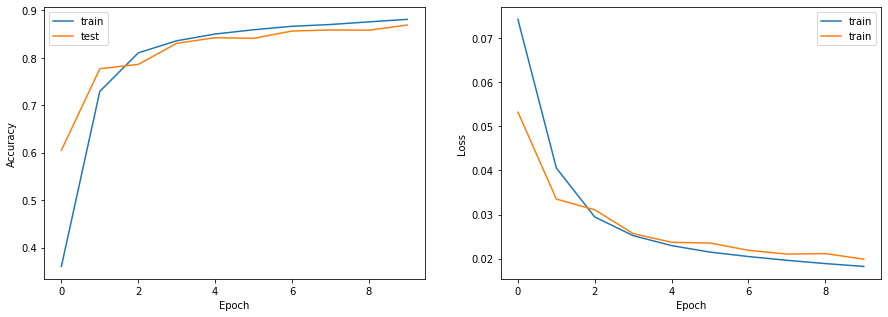

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(log['train_accuracy'])
ax1.plot(log['test_accuracy'])
ax1.legend(['train', 'test'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

ax2.plot(log['train_loss'])
ax2.plot(log['test_loss'])
ax2.legend(['train', 'train'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')